# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [4]:
!conda install -c conda-forge numpy -y
!conda install -c conda-forge pandas -y
!conda install -c conda-forge matplotlib -y
!conda install -c conda-forge boto3 -y
!conda install -c conda-forge requests -y
!conda install -c conda-forge sagemaker-python-sdk -y

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import requests
import json
import sagemaker
from IPython.display import Markdown
from markdown_helper import generate_s3_write_permission_for_sagemaker_role
import glob
%matplotlib inline

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /Users/vanderlaan/anaconda3/envs/deepracer-install-test

  added / updated specs:
    - matplotlib


The following NEW packages will be INSTALLED:

  cycler             conda-forge/noarch::cycler-0.10.0-py_2
  freetype           conda-forge/osx-64::freetype-2.10.4-h4cff582_1
  jbig               conda-forge/osx-64::jbig-2.1-h0d85af4_2003
  kiwisolver         conda-forge/osx-64::kiwisolver-1.3.1-py39hf018cea_1
  lcms2              conda-forge/osx-64::lcms2-2.12-h577c468_0
  lerc               conda-forge/osx-64::lerc-2.2.1-h046ec9c_0
  libdeflate         conda-forge/osx-64::libdeflate-1.7-h35c211d_5
  libtiff            conda-forge/osx-64::libtiff-4.3.0-h1167814_1
  libwebp-base       conda-forge/osx-64::libwebp-base-1.2.0-h0d85af4_2
  matplotlib         conda-forge/osx-64::m

In [5]:
!pip install shapely

  Using cached Shapely-1.7.1-cp39-cp39-macosx_10_9_x86_64.whl (1.0 MB)


In [6]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [7]:
from log_analysis import *
from os import listdir
from os.path import isfile, join


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [8]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    iam = boto3.client('iam')
    sagemaker_role = iam.get_role(RoleName='deepracer')['Role']['Arn']

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Couldn't call 'get_role' to get Role ARN from role name vandy to get Role path.


Using Sagemaker IAM role arn: 
arn:aws:iam::208463314099:role/deepracer


### Permission setup for Sagemaker to S3 bucket

The sagemaker wants to download simtrace from S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [9]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AmazonS3FullAccess")))

1. Go to IAM console to edit current SageMaker role: [deepracer](https://console.aws.amazon.com/iam/home#/roles/deepracer).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


### Permission setup for Sagemaker to fetch appropriate DeepRacer Artifacts

The sagemaker wants to know which deepracer jobs simtrace you want to download. This requires DeepRacer service permission. Make sure the sagemaker role you are using as this permissions.

In [10]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role, "AWSDeepRacerServiceRolePolicy")))

1. Go to IAM console to edit current SageMaker role: [deepracer](https://console.aws.amazon.com/iam/home#/roles/deepracer).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AWSDeepRacerServiceRolePolicy` policy


## Jobs run from AWS DeepRacer Console. Download the desired log file by providing model name

If the job is run from the console (https://console.aws.amazon.com/deepracer/home?region=us-east-1#) use this else comment this out.

In [11]:
model_name="free-range-deepracer-v3" ## Change to your model
is_training = True  ## Make this False if you want to do log analysis on Evaluation.

simtrace_path = "./downloaded_model/{}/sim-trace/training/training-simtrace/".format(model_name)
if not is_training:
    simtrace_path = "./downloaded_model/{}/sim-trace/evaluation/*/evaluation-simtrace/".format(model_name)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(model_name)

In [12]:
!rm -rf ./tmp
!rm -rf ./intermediate_checkpoint
!rm -rf ./downloaded_model

In [13]:
envroot = os.getcwd()
"""aws_data_path = set(os.environ.get('AWS_DATA_PATH', '').split(os.pathsep))
aws_data_path.add(os.path.join(envroot, 'models'))
os.environ.update({'AWS_DATA_PATH': os.pathsep.join(aws_data_path)})

region = "us-east-1"
dr_client = boto3.client('deepracer', region_name=region,
        endpoint_url="https://deepracer-prod.{}.amazonaws.com".format(region))"""
!pip install deepracer_utils
from deepracer import boto3_enhancer
dr_client = boto3_enhancer.deepracer_client()

models = dr_client.list_models(ModelType="REINFORCEMENT_LEARNING",MaxResults=100)["Models"]
for model in models:
    if model["ModelName"]==model_name:
        break

  Using cached deepracer_utils-0.20-py3-none-any.whl (45 kB)
     |████████████████████████████████| 7.3 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 32.1 MB 129 kB/s  eta 0:00:01


In [14]:
if is_training:
    training_job=dr_client.list_training_jobs(ModelArn=model["ModelArn"],MaxResults=100)["TrainingJobs"][0]
    training_log_url= dr_client.get_asset_url(Arn=training_job['JobArn'], AssetType="LOGS")['Url']

    with requests.get(training_log_url, stream=True) as response:
        with open("{}.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)
else:       
    evaluation_job = dr_client.list_evaluations(ModelArn=model["ModelArn"],MaxResults=100)["EvaluationJobs"][0]
    evaluation_log_url= dr_client.get_asset_url(Arn=evaluation_job['JobArn'], AssetType="LOGS")['Url']

    with requests.get(evaluation_log_url, stream=True) as response:
        with open("{}.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)

In [15]:
!mkdir -p downloaded_model/{model_name}
!mkdir -p intermediate_checkpoint/{model_name}/model-artifacts

!tar -xf {model_name}.tar.gz -C ./downloaded_model/
!mkdir -p ./tmp
!rsync -a --delete --include="*.csv" --exclude="*" {simtrace_path} ./tmp/
!rm -rf downloaded_model/{model_name}
!rm -rf {model_name}.tar.gz

In [16]:
model_url=dr_client.get_asset_url(Arn=model["ModelArn"],AssetType="COMPLETE_MODEL_ARTIFACT")['Url']
    
with requests.get(model_url, stream=True) as response:
    with open("{}-model.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)
            
!mkdir -p intermediate_checkpoint/{model_name}/model
!mkdir -p intermediate_checkpoint/{model_name}/metrics

!tar zxvf {model_name}-model.tar.gz -C intermediate_checkpoint/ \*.csv {model_name}/model {model_name}/metrics
#!rm -rf {model_name}-model.tar.gz

x free-range-deepracer-v3/metrics/evaluation/evaluation-20210703033824-qDAH-yYGT1OaLwgWTjO-Ew.json
x free-range-deepracer-v3/metrics/training/training-20210702221114-JQNsvNPWS_OWW60poPAw9A.json
x free-range-deepracer-v3/model/9_Step-5628.ckpt.data-00000-of-00001
x free-range-deepracer-v3/model/9_Step-5628.ckpt.index
x free-range-deepracer-v3/model/9_Step-5628.ckpt.meta
x free-range-deepracer-v3/model/model_10.pb
x free-range-deepracer-v3/model/model_7.pb
x free-range-deepracer-v3/model/model_8.pb
x free-range-deepracer-v3/model/model_9.pb
x free-range-deepracer-v3/model/model_metadata.json
x free-range-deepracer-v3/sim-trace/evaluation/20210703033824-qDAH-yYGT1OaLwgWTjO-Ew/evaluation-simtrace/0-iteration.csv
x free-range-deepracer-v3/sim-trace/training/training-simtrace/0-iteration.csv
x free-range-deepracer-v3/sim-trace/training/training-simtrace/1-iteration.csv
x free-range-deepracer-v3/sim-trace/training/training-simtrace/2-iteration.csv
x free-range-deepracer-v3/sim-trace/training/

In [17]:
model_url= dr_client.get_asset_url(Arn=model["ModelArn"], AssetType="MODEL_ARTIFACT")['Url']

with requests.get(model_url, stream=True) as response:
    with open("{}-model-artifacts.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

!tar zxvf {model_name}-model-artifacts.tar.gz -C intermediate_checkpoint/{model_name}/model-artifacts
!rm -rf {model_name}-model-artifacts.tar.gz

x model_metadata.json
x agent/
x agent/model.pb
x worker_0.multi_agent_graph.main_level.main_level.agent_0.csv
x worker_0.multi_agent_graph_0.json


In [18]:
with open("intermediate_checkpoint/{}/model/model_metadata.json".format(model_name),"r") as jsonin:
    model_metadata=json.load(jsonin)
sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
model_metadata

{'action_space': [{'steering_angle': -30,
   'speed': 0.3333333333333333,
   'index': 0},
  {'steering_angle': -30, 'speed': 0.6666666666666666, 'index': 1},
  {'steering_angle': -30, 'speed': 1, 'index': 2},
  {'steering_angle': 0, 'speed': 0.3333333333333333, 'index': 3},
  {'steering_angle': 0, 'speed': 0.6666666666666666, 'index': 4},
  {'steering_angle': 0, 'speed': 1, 'index': 5},
  {'steering_angle': 30, 'speed': 0.3333333333333333, 'index': 6},
  {'steering_angle': 30, 'speed': 0.6666666666666666, 'index': 7},
  {'steering_angle': 30, 'speed': 1, 'index': 8}],
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '4'}

## Job run from Public Notebook. Download the desired log file given the simulation ID 

#### Merge all the csv files into one big .csv file

In [19]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    fout.write(line)

merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

79,352.0,0.8445551464064311,0.6528449536750919,58.65643209750548,-30.0,1.0,2,0.01,False,False,27.006356655728354,50,59.35085588912497,1500.801,in_progress,0.0
79,353.0,0.8716940549497718,0.7275045799809516,62.10185162826104,0.0,0.6666666666666666,4,0.01,False,False,27.006356655728354,50,59.35085588912497,1500.876,in_progress,0.0
79,354.0,0.8900687705886015,0.7837252700820896,64.42995407908609,30.0,0.3333333333333333,6,0.01,True,False,27.006356655728354,50,59.35085588912497,1500.929,off_track,0.0


## Load waypoints for the track you want to run analysis on


In [20]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['reInvent2019_track.npy', 'Aragon.npy', 'jyllandsringen_open.npy', 'hamption_pro.npy', 'Monaco_building.npy', 'Canada_Training.npy', 'reInvent2019_wide.npy', 'thunder_hill_pro.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'reInvent2019_wide_mirrored.npy', 'AmericasGeneratedInclStart.npy', 'jyllandsringen_pro.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'Belille.npy', 'Austin.npy', 'H_track.npy', 'Singapore.npy', 'reinvent_base.npy', 'Mexico_track.npy', 'Spain_track.npy', 'Vegas_track.npy', 'Virtual_May19_Train_track.npy', 'arctic_pro.npy', 'Straight_track.npy', 'AWS_track.npy', 'dubai_pro.npy', 'hamption_open.npy', 'Singapore_f1.npy', 'Albert.npy', 'penbay_pro.npy', 'Spain_track_f1.npy', 'thunder_hill_open.npy', 'China_track.npy', 'Monaco.npy', 'LGSWide.npy', 'Singapore_building.npy', 'penbay_open.npy', 'July_2020.npy', 'arctic_open.npy', 'dubai_open.npy', 'FS_June2020.npy', 'London_Loop_Train.npy', 'ChampionshipCup2019_track.npy']


In [21]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

if is_training:
    track_arn=training_job["Config"]["TrackConfig"]["TrackArn"]
else:
    track_arn=evaluation_job["Config"]["TrackArn"]

trackname=track_arn[track_arn.rfind("/")+1:]
waypoints = get_track_waypoints(trackname)
waypoints.shape

(224, 6)

## Visualize the Track and Waypoints

In [22]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

In [23]:
track_segments_hash = { "reinvent_base": [(0, 'straightaway'),
                                          (20, 'hairpin'),
                                          (46, 'slight right'),
                                          (61, 'left'),
                                          (76, 'slight left'),
                                          (90, 'straightaway'),
                                          (103, 'left'),
                                          (113, 'straightaway')                                         
                                          ],
                       "reInvent2019_track": [(0, 'left'),
                                              (18, 'sharp right'),
                                              (33, 'gentle left'),
                                              (82, 'left'),
                                              (93, 'slight left'),
                                              (107, 'left'),
                                              (117, 'right'),
                                              (137, 'left')
                                             ],
                       "arctic_open": [(0, 'straightaway'),
                                       (24,'left'),
                                       (36,'right'),
                                       (52,'left'),
                                       (67,'hairpin left'),
                                       (84,'right'),
                                       (98,'slight left'),
                                       (107,'straightaway'),
                                       (125,'slight left'),
                                       (134,'straightaway'),
                                       (156,'hairpin left')            
                       ],
                       "Singapore_building": [(0,'straightaway'),
                                             (13,'slight left'),
                                             (27,'hairpin left'),
                                             (42, 'straightaway'),
                                             (51, 'right'),
                                             (65, 'straightaway'),
                                             (77, 'slight right'),
                                             (82, 'straightaway'),
                                             (96, 'left'),
                                             (110, 'right'),
                                             (120, 'left'),
                                             (131, 'straightaway'),
                                             (145, 'slight left'),
                                             (155, 'straightaway'),
                                             (176, 'hairpin left'),
                                             (190, 'straightaway'),
                                             (201, 'hairpin right'),
                                             (214, 'straightaway'),
                                             (230, 'slight left'),
                                             (248, 'right'),
                                             (268, 'slight left'),
                                             (272, 'straightaway'),
                                             (280, 'left'),
                                             (293, 'straightaway')
                       ],
                       "Austin": [(0, 'str'),
                                 (10, 'left'),
                                 (21, 'zigzag'),
                                 (52, 'zigzag'),
                                 (81, 'hp left'),
                                 (93, 'str'),
                                 (119, 'left'),
                                 (130, 'u-curves'),
                                 (185, 'left'),
                                 (198, 'hp left'),
                                 (205, 'str')]
                       
}
trackname

'Austin'

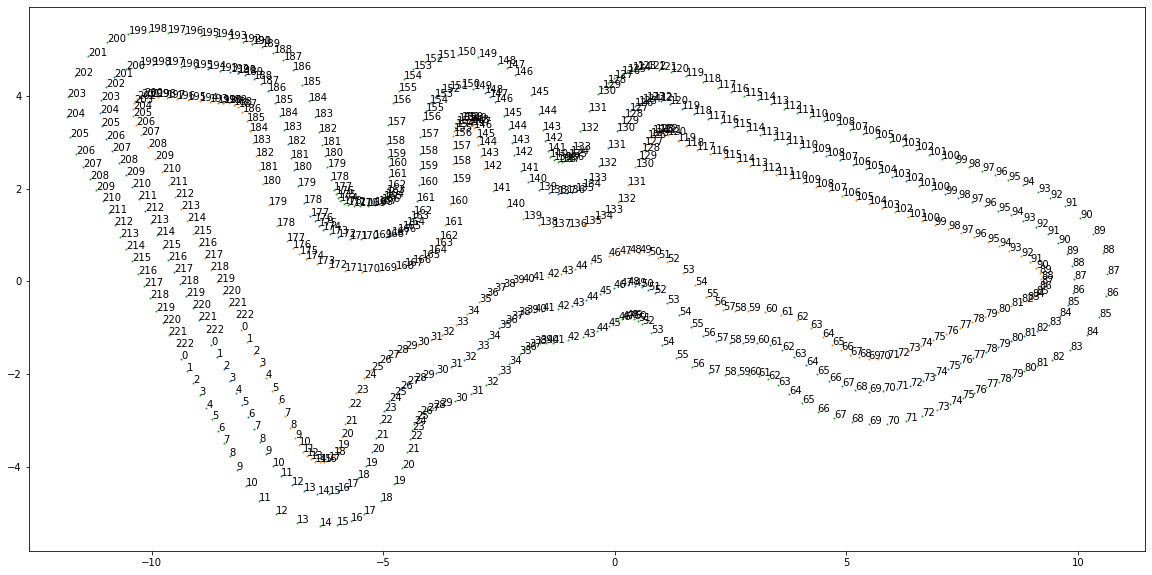

In [24]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

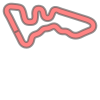

In [25]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [26]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [27]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
        #plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [28]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

In [29]:
EPISODE_PER_ITER = 20 if is_training else 1

In [30]:
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,iteration
0,0,1.0,-8.657278,-1.488846,-62.526168,0.0,0.333333,3,0.000000,False,True,0.236132,0,59.350856,19.508,prepare,0.0,1
1,0,2.0,-8.657348,-1.488718,-62.525153,0.0,0.333333,3,11.905381,False,True,0.235885,0,59.350856,19.597,in_progress,0.0,1
2,0,3.0,-8.653134,-1.497078,-62.567605,-30.0,0.666667,1,8.833075,False,True,0.251659,1,59.350856,19.616,in_progress,0.0,1
3,0,4.0,-8.642446,-1.522593,-63.150389,30.0,0.333333,6,7.563801,False,True,0.298108,1,59.350856,19.718,in_progress,0.0,1
4,0,5.0,-8.630883,-1.548030,-63.422633,0.0,0.666667,4,7.346870,False,True,0.345121,1,59.350856,19.785,in_progress,0.0,1


In [31]:
df['y'].min(), df['x'].max()

(-4.456792623579907, 10.894176658318356)

In [32]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [33]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  79


Text(0.5, 0, 'Episode')

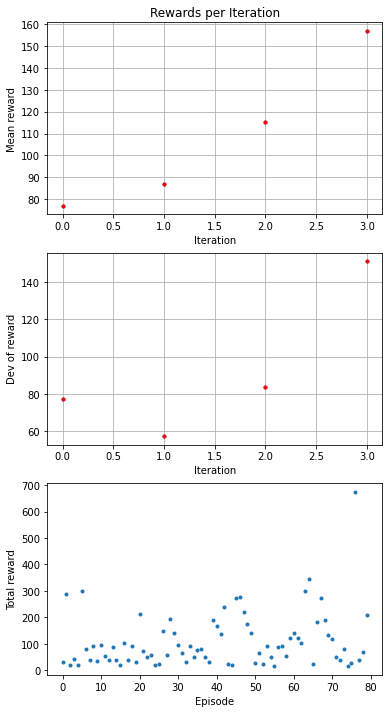

In [34]:
REWARD_THRESHOLD = 0

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes+1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze training/evaluation metrics with progress and reward function

This graph gives you an idea whether your model has convergered or more training is required. If you see the curve trending upwards then more training time would help the agent to get better rewards

In [35]:
if is_training:
    METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/training/*.json".format(model_name))[0]
else:
    METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/evaluation/*.json".format(model_name))[0]
    
with open(METRIC_PATH, "r") as fp:
    data = json.loads(fp.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

if is_training:
    df_metrics = df_metrics[df_metrics['phase'] == "training"]

In [36]:
df_metrics

,reward_score,metric_time,start_time,elapsed_time_in_milliseconds,episode,trial,phase,completion_percentage,episode_status
0,409,23597,19459,4138,1,1,training,5,Off track
1,3845,54836,23666,31170,2,2,training,36,Off track
2,250,57797,54932,2865,3,3,training,2,Off track
3,565,62386,57856,4530,4,4,training,5,Off track
4,275,65796,62419,3377,5,5,training,2,Off track
...,...,...,...,...,...,...,...,...,...
90,385,1389610,1384740,4870,76,16,training,3,Off track
91,8965,1463851,1389678,74173,77,17,training,91,Off track
92,528,1468871,1463948,4923,78,18,training,4,Off track
93,907,1477285,1468940,8345,79,19,training,8,Off track


Mean percentage: 13.625


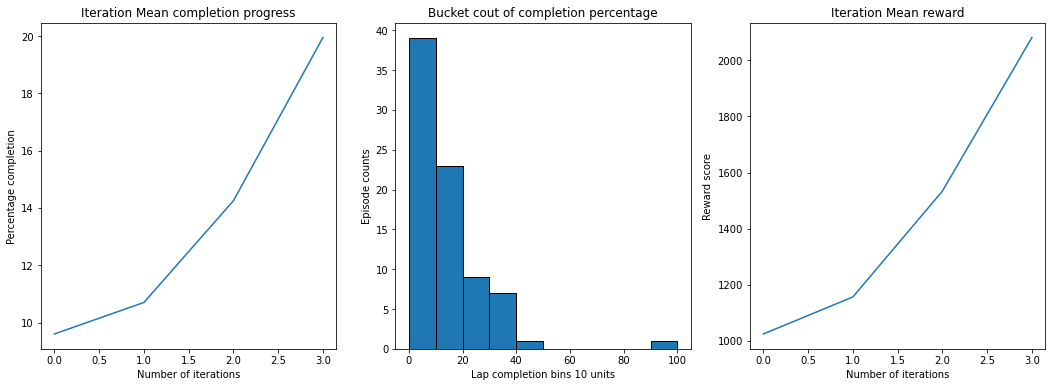

In [37]:
bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

df_metrics = df_metrics.sort_values(by="metric_time")
print('Mean percentage: {}'.format(df_metrics.completion_percentage.mean()))

completion_percentage_np = np.array(df_metrics.completion_percentage)
episode_progress_buckets = np.split(completion_percentage_np[:EPISODE_PER_ITER*(len(completion_percentage_np)//EPISODE_PER_ITER)],
                                    len(completion_percentage_np)//EPISODE_PER_ITER)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
ax2.hist(df_metrics.completion_percentage, bins=bins, edgecolor="k")
ax2.title.set_text('Bucket cout of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
if is_training:
    reward_score_np = np.array(df_metrics.reward_score)
    episode_reward_buckets = np.split(reward_score_np[:EPISODE_PER_ITER*(len(reward_score_np)//EPISODE_PER_ITER)],
                                                      len(reward_score_np)//EPISODE_PER_ITER)
    episode_reward_mean = np.mean(episode_reward_buckets, axis=1)
    ax3.plot(episode_reward_mean)
    plt.title("Metric analysis - Reward/percentage vs number of iterations")
    ax3.title.set_text('Iteration Mean reward')
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Reward score')
    plt.show()


## Analyze the reward distribution for your reward function

In [38]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis -12.07355325154518; Max x-axis 10.894176658318356
Min y-axis -4.456792623579907; Max y-axis 5.407992020863759


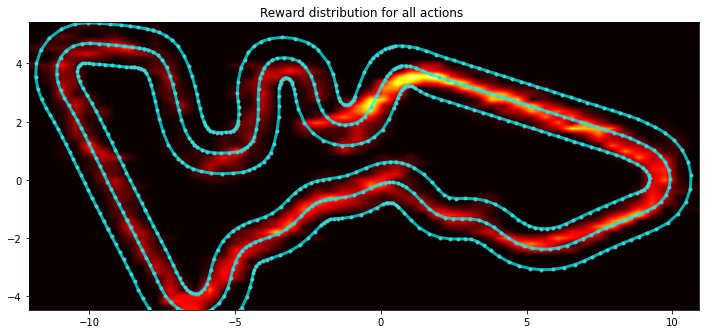

In [39]:
track,extent = plot_track(df, track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Plot a particular iteration


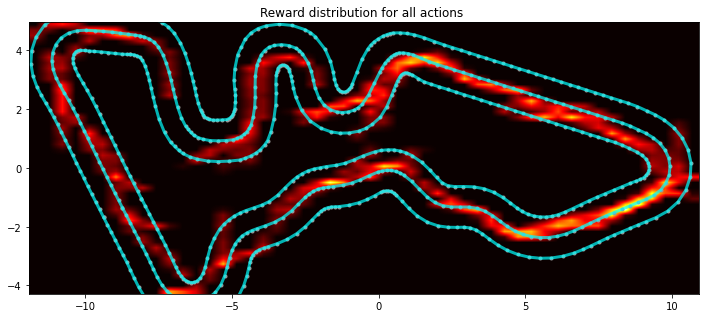

In [40]:
iteration_id = 1
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

The top 3 highest reward episodes are [76, 64, 63]


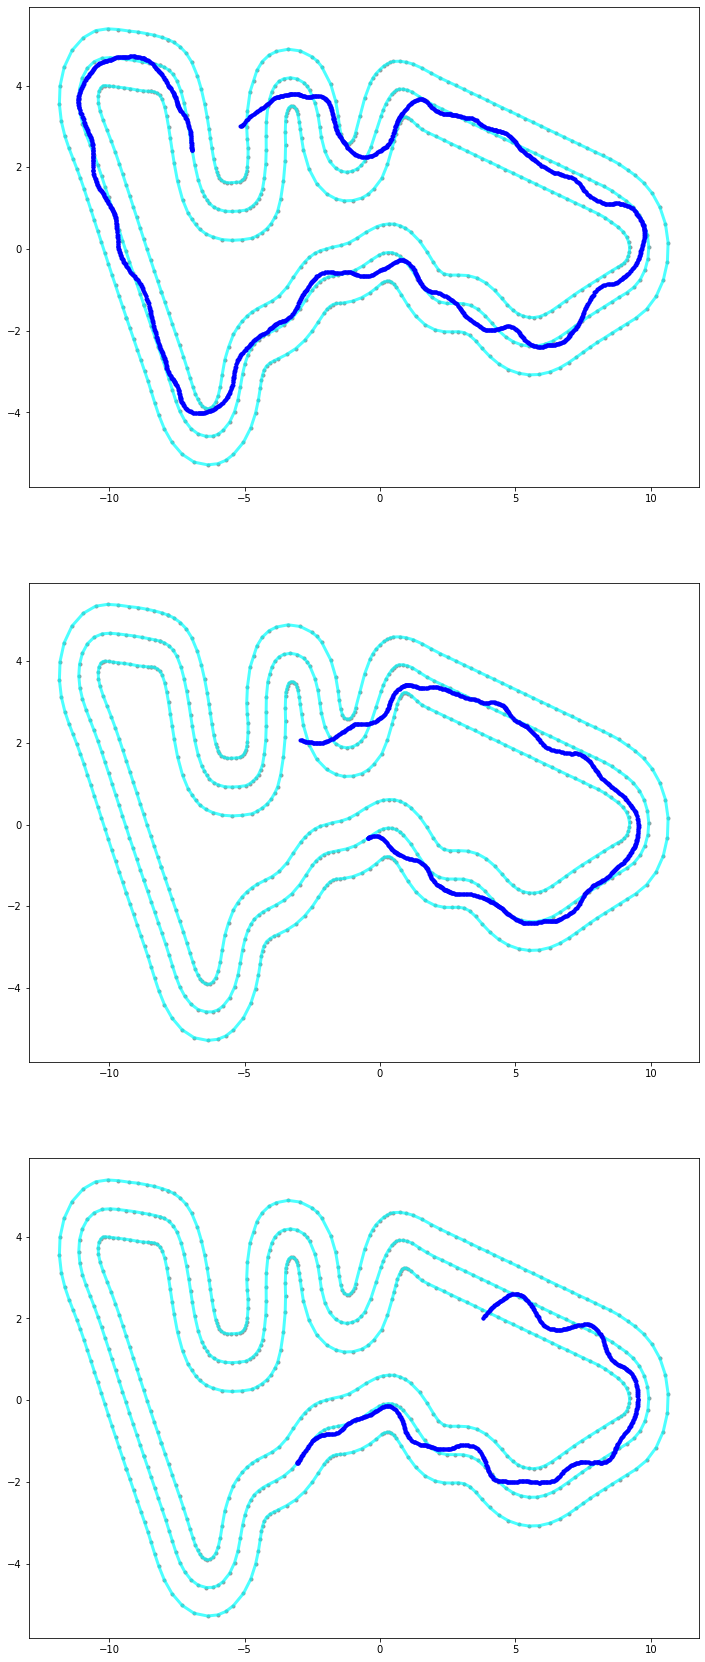

In [41]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Path taken in a particular episode

In [42]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

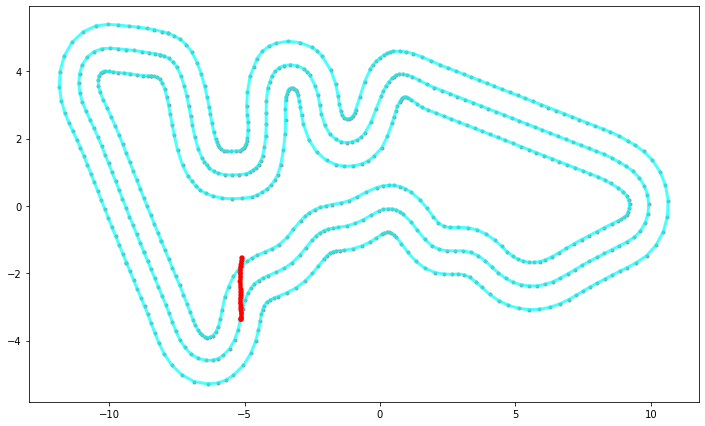

In [43]:
plot_episode_run(df, E=2) # arbitrary episode

### Path taken in a particular Iteration

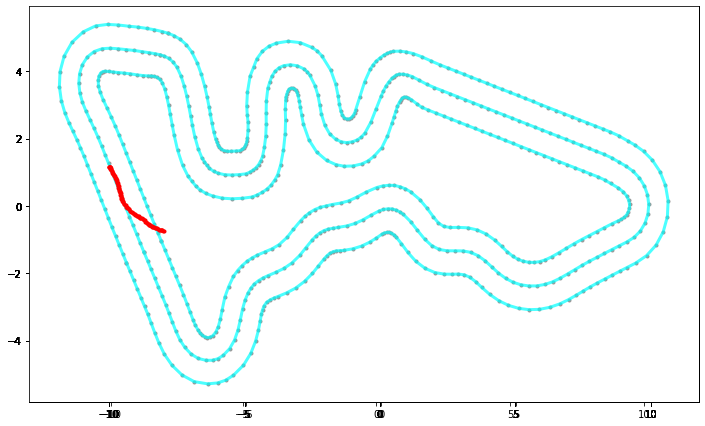

In [44]:
iteration_id = 1

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

Say you want the car to go at higher speeds on the straight line. This will give you an idea what actions the car is taking along those segments

In [45]:
# The actions plotted on the tracks may become noise. Use this to clip the low reward values action.
# Anything with reward < 0.8 is clipped. This is based on the reward function you trained on.

REWARD_THRESHOLD = 0.8

In [46]:
# Track Segment Labels
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
action_names

['ST-30 SP0.33',
 'ST-30 SP0.67',
 'ST-30 SP1.00',
 'ST0 SP0.33',
 'ST0 SP0.67',
 'ST0 SP1.00',
 'ST30 SP0.33',
 'ST30 SP0.67',
 'ST30 SP1.00']

**Define track labels**

This hash defines the labels for track segments on various tracks. Analyzing new tracks will require adding a new entry to this hash.

Number of steps in iteration= 2644


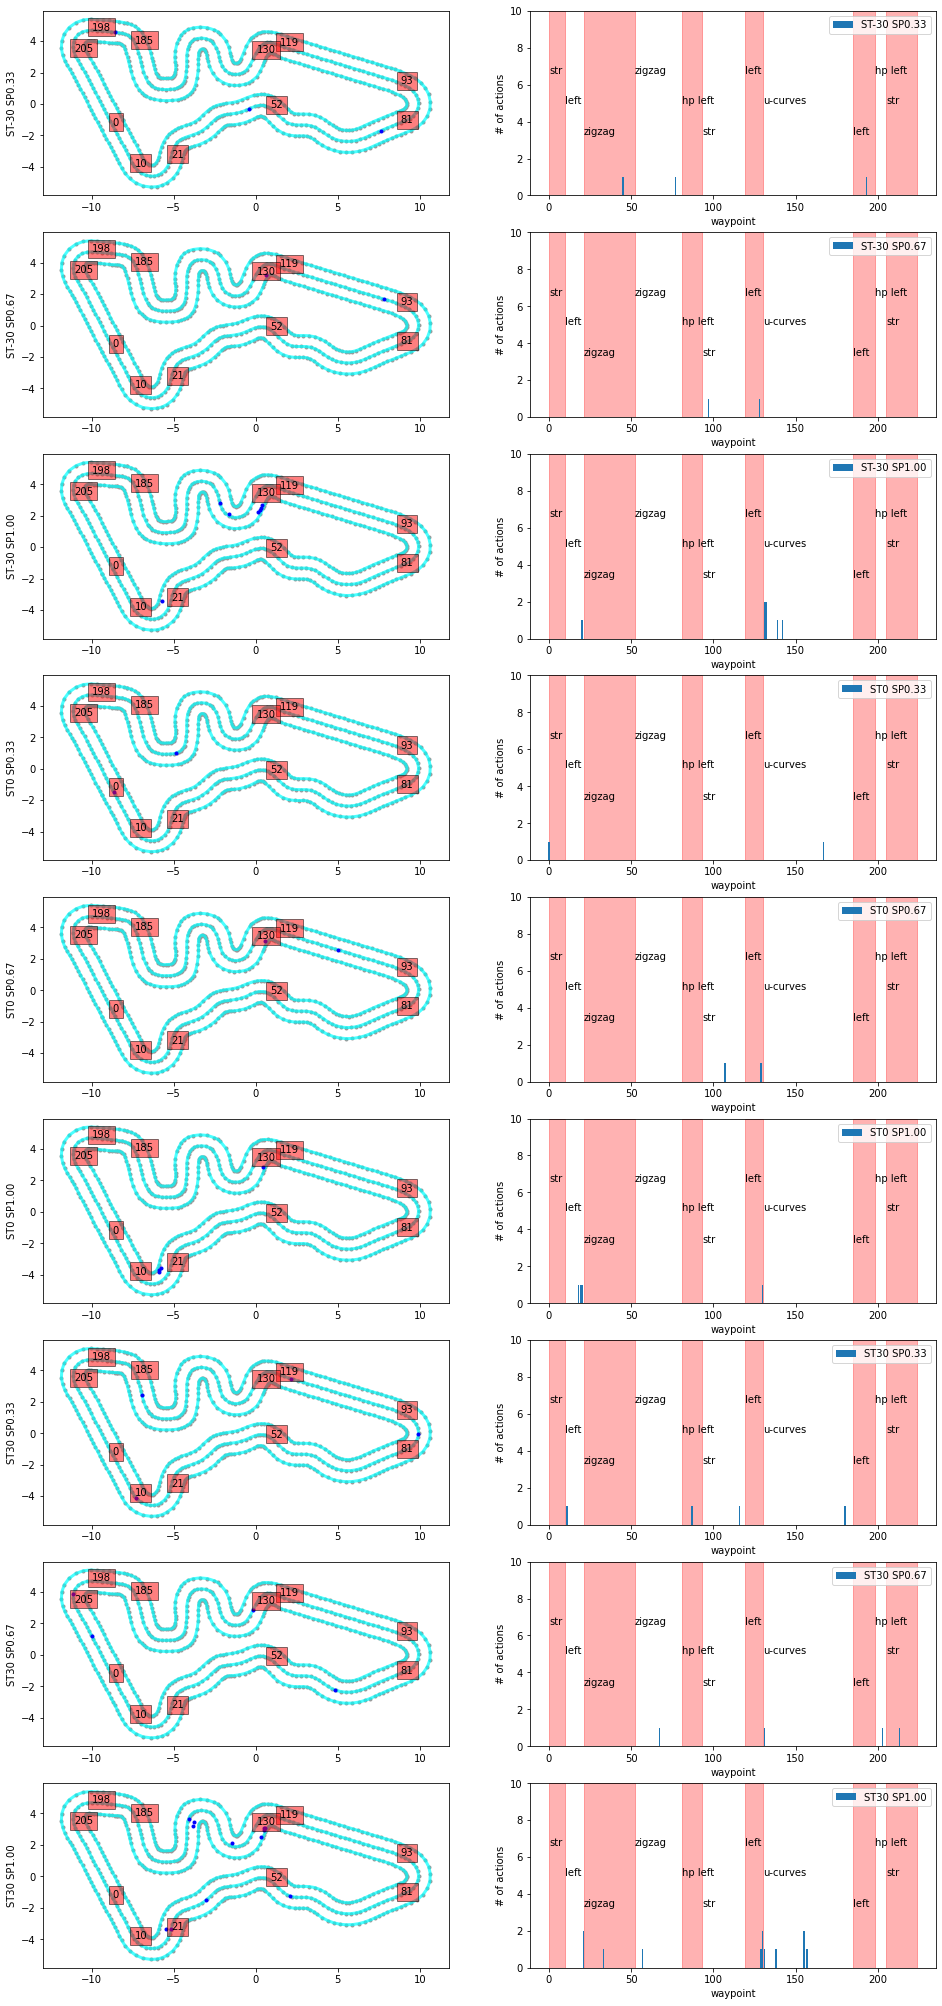

In [47]:
fig = plt.figure(figsize=(16, 4*len(action_names)))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

y_limit = 10
track_segments = track_segments_hash[trackname]
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(track_segments):
    segment_x.append(track_segments[i][0])
    segment_y.append(0)
    segment_xerr_l.append(0)
    if i>=len(track_segments)-1:
        segment_xerr_r.append(len(waypoints)-track_segments[i][0])
    else:
        segment_xerr_r.append(track_segments[i+1][0]-track_segments[i][0])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

#segment_x = np.array(vert_lines)
#segment_y = np.array([0]*len(vert_lines))
#segment_xerr = np.array([[0]*len(vert_lines),[1]*len(vert_lines)])
#segment_yerr = np.array([[0]*len(vert_lines), [150]*len(vert_lines)])

wpts_array = center_line 
text_y=[.66*y_limit,.5*y_limit,.33*y_limit]
    
for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    # Reward function threshold
    th = REWARD_THRESHOLD
    for idx in range(len(action_names)):
        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in track_segments:
            ax.text(wpts_array[idWp[0]][0], wpts_array[idWp[0]][1], str(idWp[0]), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)


        i=0
        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], text_y[i], track_segments[tt][1])
            i = (i+1)%len(text_y)

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))

Lets analyze the hairpin turn for the best iteration. We see that the model like to take Slight left and Straight over other actions, we see that slight right and right actions frequency is very low in comparison. In short, this model seems to do well for the hairpin turn 

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [48]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

#### Download all the checkpoints (provided as an example).  
We recommend downloading only the ones you are interested in


In [50]:
!conda install -c conda-forge tensorflow -y

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # For front cameras/stereo camera use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /Users/vanderlaan/anaconda3/envs/deepracer-install-test

  added / updated specs:
    - tensorflow


The following NEW packages will be INSTALLED:

  abseil-cpp         conda-forge/osx-64::abseil-cpp-20210324.0-he49afe7_0
  absl-py            conda-forge/noarch::absl-py-0.13.0-pyhd8ed1ab_0
  aiohttp            conda-forge/osx-64::aiohttp-3.7.4.post0-py39h89e85a6_0
  astor              conda-forge/noarch::astor-0.8.1-pyh9f0ad1d_0
  astunparse         conda-forge/noarch::astunparse-1.6.3-pyhd8ed1ab_0
  async-timeout      conda-forge/noarch::async-timeout-3.0.1-py_1000
  blinker            conda-forge/noarch::blinker-1.4-py_1
  c-ares             conda-forge/osx-64::c-ares-1.17.1-h0d85af4_1
  cachetools         conda-forge/noarch

In [51]:
model_inference = []
iterations = [7,8,9]
models_file_path = glob.glob("{}{}/model/model_*.pb".format(GRAPH_PB_PATH, model_name))

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

Device mapping: no known devices.
load graph: intermediate_checkpoint/free-range-deepracer-v3/model/model_10.pb
Instructions for updating:
Use tf.gfile.GFile.


2021-07-05 15:02:17.787890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-05 15:02:17.953217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-07-05 15:02:17.953869: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:17.953884: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:17.953892: I tensorflow/core/common_runtime/placer.cc:114] main_leve

Device mapping: no known devices.
load graph: intermediate_checkpoint/free-range-deepracer-v3/model/model_7.pb


2021-07-05 15:02:23.922781: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:23.922805: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:23.922811: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:23.922816: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:23.922820: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

Device mapping: no known devices.
load graph: intermediate_checkpoint/free-range-deepracer-v3/model/model_9.pb
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/BatchnormActivationDropout_1_activation: (Relu): /jo

2021-07-05 15:02:29.909576: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:29.909613: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:29.909713: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:29.909721: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:29.909727: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

Device mapping: no known devices.
load graph: intermediate_checkpoint/free-range-deepracer-v3/model/model_8.pb


2021-07-05 15:02:36.078780: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:36.078834: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:36.078847: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:36.078854: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:02:36.078860: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

Inference for model: intermediate_checkpoint/free-range-deepracer-v3/model/model_10.pb


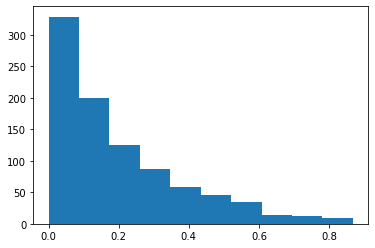

Inference for model: intermediate_checkpoint/free-range-deepracer-v3/model/model_7.pb


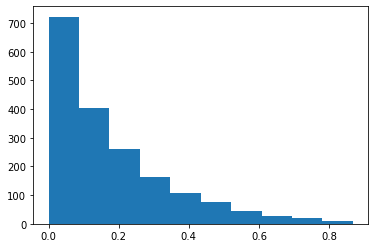

Inference for model: intermediate_checkpoint/free-range-deepracer-v3/model/model_9.pb


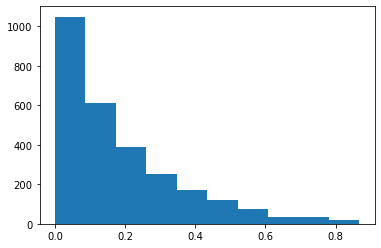

Inference for model: intermediate_checkpoint/free-range-deepracer-v3/model/model_8.pb


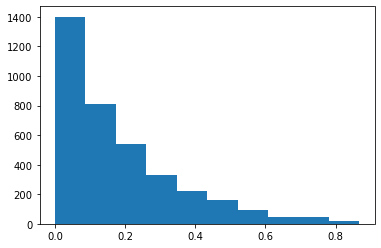

In [52]:
prob_diff = []

for model, model_file in zip(model_inference, models_file_path):
    print("Inference for model: {}".format(model_file))
    for mi in model:
        max1, max2 = mi.argsort()[-2:][::-1]
        prob_diff.append(mi[max1] - mi[max2])
    plt.hist(prob_diff)
    plt.show()

The model which appears to have a better seperation in probabability will work better in sim2real experiments

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [53]:
fname = './intermediate_checkpoint/{}/model-artifacts/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'.format(model_name)
df_csv = pd.read_csv(fname)

In [54]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward',
       'Doubly Robust', 'Weighted Importance Sampling',
       'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max',
       'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev',
       'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min',

<AxesSubplot:title={'center':'Training'}, xlabel='Training Iter'>

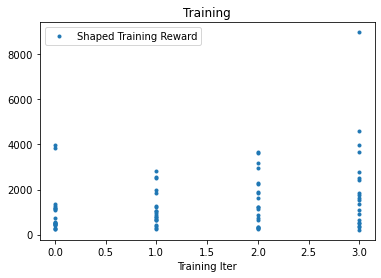

In [55]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

<AxesSubplot:>

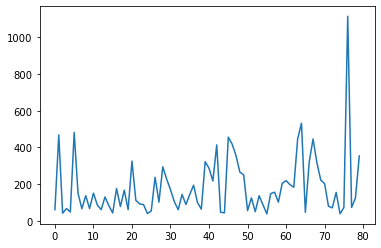

In [56]:
df_csv['Episode Length'].plot()

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [58]:
!conda install -c conda-forge opencv -y

import cv2
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

Solving environment: done

## Package Plan ##

  environment location: /Users/vanderlaan/anaconda3/envs/deepracer-install-test

  added / updated specs:
    - opencv


The following NEW packages will be INSTALLED:

  bzip2              conda-forge/osx-64::bzip2-1.0.8-h0d85af4_4
  cairo              conda-forge/osx-64::cairo-1.16.0-he43a7df_1008
  ffmpeg             conda-forge/osx-64::ffmpeg-4.3.1-hb787a4c_2
  fontconfig         conda-forge/osx-64::fontconfig-2.13.1-h10f422b_1005
  gmp                conda-forge/osx-64::gmp-6.2.1-h2e338ed_0
  gnutls             conda-forge/osx-64::gnutls-3.6.13-h756fd2b_1
  graphite2          conda-forge/osx-64::graphite2-1.3.13-h2e338ed_1001
  harfbuzz           conda-forge/osx-64::harfbuzz-2.8.1-h159f659_0
  jasper             conda-forge/osx-64::jasper-1.900.1-h636a363_1006
  lame               conda-forge/osx-64::lame-3.100-h35c211d_1001
  liblapacke         conda-forge/osx-64::liblapacke-3.9.0-9_openblas
  libopencv          conda-forge/osx-64::li

In [59]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [60]:
model_path = models_file_path[0] #Change this to your model 'pb' frozen graph file

model, obs, model_out = load_session(model_path)
heatmaps = []
for f in all_files[:5]:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(action_names))
    heatmaps.append(heatmap)
tf.reset_default_graph()

Device mapping: no known devices.
load graph: intermediate_checkpoint/free-range-deepracer-v3/model/model_10.pb
ACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/BatchnormActivationDropout_1_activation: (Relu): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/bias/read: (Identity): /job:localhost

2021-07-05 15:03:48.385500: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:48.385532: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:48.385540: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:48.385547: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:48.385563: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

2021-07-05 15:03:49.307581: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:49.307604: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:49.307610: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:49.307615: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:49.307620: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

/task:0/device:CPU:0
gradients/main_level/agent/main/online/network_1/ppo_head_0/strided_slice_grad/StridedSliceGrad/strides: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRO

2021-07-05 15:03:50.255546: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:50.255565: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:50.255571: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:50.255575: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:50.255580: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

ica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/main_level/agent/main/online/network_1/mul_grad/Reshape_1: (Reshape): /job:localhost/repl

2021-07-05 15:03:51.192296: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:51.192316: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:51.192322: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:51.192328: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:51.192333: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

SliceGrad: (StridedSliceGrad): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/add_grad/Shape: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/add_grad/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/add_grad/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/add_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/add_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/add_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/online/network_1/add_grad/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_2/main_level/agent/main/onlin

2021-07-05 15:03:52.133831: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:52.133860: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:52.133869: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:52.133877: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-05 15:03:52.133885: I tensorflow/core/common_runtime/placer.cc:114] main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/repli

T_FACING_CAMERA/Flatten/flatten/strided_slice/stack_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Flatten/flatten/strided_slice/stack_2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Flatten/flatten/Reshape/shape/1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/middleware_fc_embedder/Dense_0/kernel: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/middleware_fc_embedder/Dense_0/bias: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/gradients_from_head_0-0_rescalers: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/sub/x: (Const): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/ppo_head_0/strided_slice/stack: (Const): /job:localhost/replica:

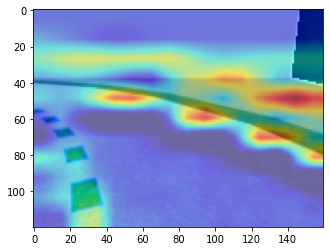

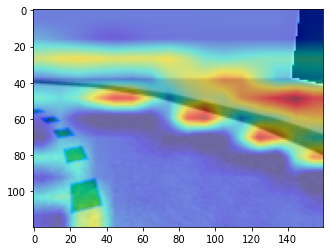

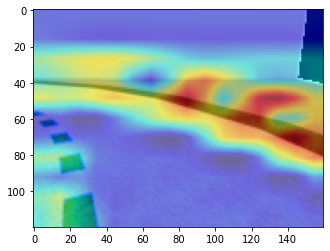

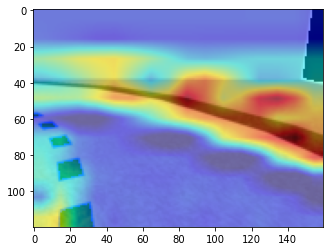

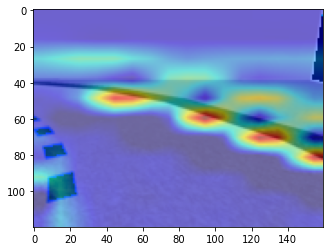

In [61]:
for i in range(len(heatmaps)):
    plt.imshow(heatmaps[i])
    plt.show()